# Imports and loading in cleaned data

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier,XGBRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
df = pd.read_csv('./data/cleaned_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45113 entries, 0 to 45112
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                45113 non-null  int64  
 1   Month                     45113 non-null  object 
 2   Age                       45113 non-null  float64
 3   Annual_Income             45113 non-null  float64
 4   Monthly_Inhand_Salary     45113 non-null  float64
 5   Num_Bank_Accounts         45113 non-null  int64  
 6   Num_Credit_Card           45113 non-null  int64  
 7   Interest_Rate             45113 non-null  int64  
 8   Num_of_Loan               45113 non-null  float64
 9   Delay_from_due_date       45113 non-null  int64  
 10  Num_of_Delayed_Payment    45113 non-null  float64
 11  Num_Credit_Inquiries      44239 non-null  float64
 12  Credit_Mix                45113 non-null  object 
 13  Outstanding_Debt          45113 non-null  float64
 14  Credit

In [6]:
df['Credit_Score'].value_counts()

Standard    24916
Poor        13407
Good         6790
Name: Credit_Score, dtype: int64

# Test Train Split 

In [7]:
X = df.drop(['Credit_Score','Unnamed: 0','Month','Delay_from_due_date','Num_of_Delayed_Payment','Monthly_Balance','Interest_Rate','Credit_Mix'], axis=1)
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.2)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45113 entries, 0 to 45112
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       45113 non-null  float64
 1   Annual_Income             45113 non-null  float64
 2   Monthly_Inhand_Salary     45113 non-null  float64
 3   Num_Bank_Accounts         45113 non-null  int64  
 4   Num_Credit_Card           45113 non-null  int64  
 5   Num_of_Loan               45113 non-null  float64
 6   Num_Credit_Inquiries      44239 non-null  float64
 7   Outstanding_Debt          45113 non-null  float64
 8   Credit_Utilization_Ratio  45113 non-null  float64
 9   Credit_History_Age        40948 non-null  float64
 10  Payment_of_Min_Amount     45113 non-null  object 
 11  Amount_invested_monthly   45113 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 4.1+ MB


In [9]:
print(X_train.shape, X_test.shape)

(36090, 12) (9023, 12)


In [10]:
X.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly
0,23.0,19114.12,1824.843333,3,4,4.0,4.0,809.98,26.822620,22.0,No,80.415295
1,23.0,19114.12,1824.843333,3,4,4.0,4.0,809.98,22.537593,22.0,No,178.344067
2,23.0,19114.12,1824.843333,3,4,4.0,4.0,809.98,23.933795,NaN,No,24.785217
3,28.0,34847.84,3037.986667,2,4,1.0,2.0,605.03,24.464031,26.0,No,104.291825
4,28.0,34847.84,3037.986667,2,4,1.0,2.0,605.03,38.550848,26.0,No,40.391238


# Preprocessing Pipeline

In [11]:
#subpipes that scale numeric data and use one hot encoder on categorical 
subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [12]:
#Create a column transformer to apply the subpipes and transform the data
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
     ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

# Final Chosen Model XGB

In [15]:
xgb_final_model = ImPipeline(steps=[('CT', CT),
                                  
                              ('xgb', XGBClassifier(
                    max_depth=6,
                    min_child_weight=.1,
                    reg_alpha=1,
                    n_estimators=300,
                    learning_rate=.095,
                    max_delta_step=.065,
                              ))])

In [16]:
xgb_final_model.fit(X_train,y_train)

[20:08:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015586B5B340>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

In [17]:
xgb_final_model.score(X_train,y_train)

0.7311997783319479

In [18]:
xgb_final_model.score(X_test,y_test)

0.7158373046658539

In [19]:
xgb_final_model[1].feature_importances_
feat_import = {name: score 
                   for name, score
                       in zip(X_train.columns, xgb_final_model[1].feature_importances_)
}
feat_import

{'Age': 0.017790388,
 'Annual_Income': 0.020710114,
 'Monthly_Inhand_Salary': 0.024270179,
 'Num_Bank_Accounts': 0.05551223,
 'Num_Credit_Card': 0.14713904,
 'Num_of_Loan': 0.028746702,
 'Num_Credit_Inquiries': 0.049580228,
 'Outstanding_Debt': 0.23257218,
 'Credit_Utilization_Ratio': 0.009076431,
 'Credit_History_Age': 0.023876535,
 'Payment_of_Min_Amount': 0.012732752,
 'Amount_invested_monthly': 0.027099472}

In [20]:
values = []
keys = []
for x in feat_import:
    if feat_import[x] > .01:
        keys.append(x)
        values.append(feat_import[x])

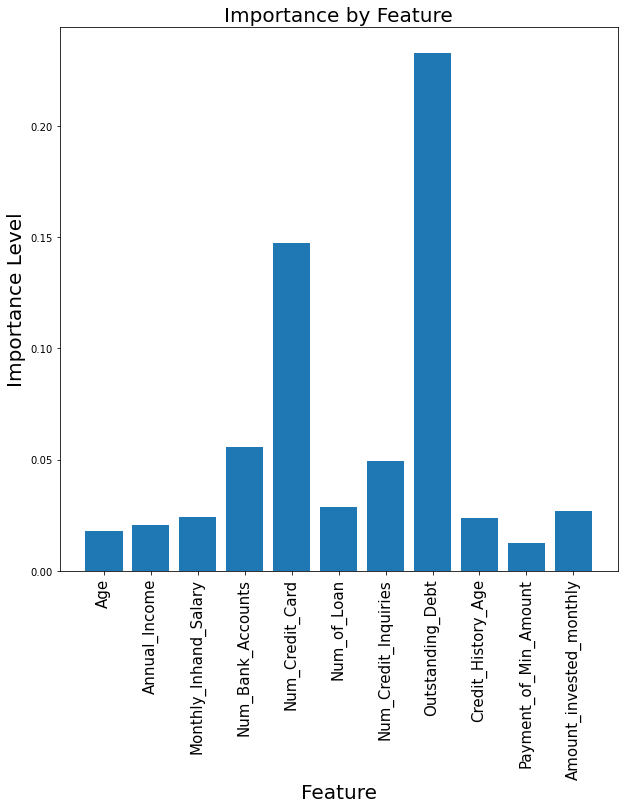

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(keys,values)

plt.xticks(rotation=90,size=15)
plt.title('Importance by Feature',size=20)
plt.xlabel('Feature',size=20)
plt.ylabel('Importance Level',size=20);

In [22]:
y_pred = xgb_final_model.predict(X_test)

In [23]:
print("Accuracy Score : ",accuracy_score(y_test, y_pred, 
                                           ))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average='weighted'))
print("f1 Score : ",f1_score(y_test, y_pred, 
                                           average='weighted'))

Accuracy Score :  0.7158373046658539
Precision Score :  0.7104263278109375
Recall Score :  0.7158373046658539
f1 Score :  0.707291629830969


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.62      0.39      0.48      1323
        Poor       0.74      0.69      0.71      2719
    Standard       0.72      0.82      0.77      4981

    accuracy                           0.72      9023
   macro avg       0.69      0.63      0.65      9023
weighted avg       0.71      0.72      0.71      9023



In [25]:
import pickle
pickle.dump(xgb_final_model, open("streamlit_model.sav", 'wb'))

In [26]:
loaded_model = pickle.load(open("streamlit_model.sav", 'rb'))

In [27]:
loaded_model.score(X_test, y_test)

0.7158373046658539